In [8]:
import pandas as pd
import os

# Load the first few rows of the dataset to understand its structure
sample_data = pd.read_csv('taxi_tripdata.csv', nrows=5)
sample_data

(   VendorID lpep_pickup_datetime lpep_dropoff_datetime store_and_fwd_flag  \
 0         1  2021-07-01 00:30:52   2021-07-01 00:35:36                  N   
 1         2  2021-07-01 00:25:36   2021-07-01 01:01:31                  N   
 2         2  2021-07-01 00:05:58   2021-07-01 00:12:00                  N   
 3         2  2021-07-01 00:41:40   2021-07-01 00:47:23                  N   
 4         2  2021-07-01 00:51:32   2021-07-01 00:58:46                  N   
 
    RatecodeID  PULocationID  DOLocationID  passenger_count  trip_distance  \
 0           1            74           168                1           1.20   
 1           1           116           265                2          13.69   
 2           1            97            33                1           0.95   
 3           1            74            42                1           1.24   
 4           1            42           244                1           1.10   
 
    fare_amount  extra  mta_tax  tip_amount  tolls_amount  e

In [9]:
# Check the size of the dataset
file_size = os.path.getsize('taxi_tripdata.csv')

# Convert bytes to megabytes for easier interpretation
file_size_MB = file_size / (1024 * 1024)

file_size_MB

7.240017890930176

In [11]:
# Load the full dataset
data = pd.read_csv('taxi_tripdata.csv')

# Get basic statistics for the numerical columns
basic_stats = data.describe()

# Check for missing values across all columns
missing_values = data.isnull().sum()

basic_stats, missing_values

<ipython-input-11-d317f6725d2e>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('taxi_tripdata.csv')


(           VendorID    RatecodeID  PULocationID  DOLocationID  \
 count  51173.000000  51173.000000  83691.000000  83691.000000   
 mean       1.851113      1.159244    108.362572    133.270005   
 std        0.355981      0.773260     70.370170     77.216791   
 min        1.000000      1.000000      3.000000      1.000000   
 25%        2.000000      1.000000     56.000000     69.000000   
 50%        2.000000      1.000000     75.000000    132.000000   
 75%        2.000000      1.000000    166.000000    205.000000   
 max        2.000000      5.000000    265.000000    265.000000   
 
        passenger_count  trip_distance   fare_amount         extra  \
 count     51173.000000   83691.000000  83691.000000  83691.000000   
 mean          1.307858     194.354699     20.388305      1.156707   
 std           0.984362    4405.549221     15.583552      1.367897   
 min           0.000000       0.000000   -150.000000     -4.500000   
 25%           1.000000       1.350000      9.000000  

# Preprocessing

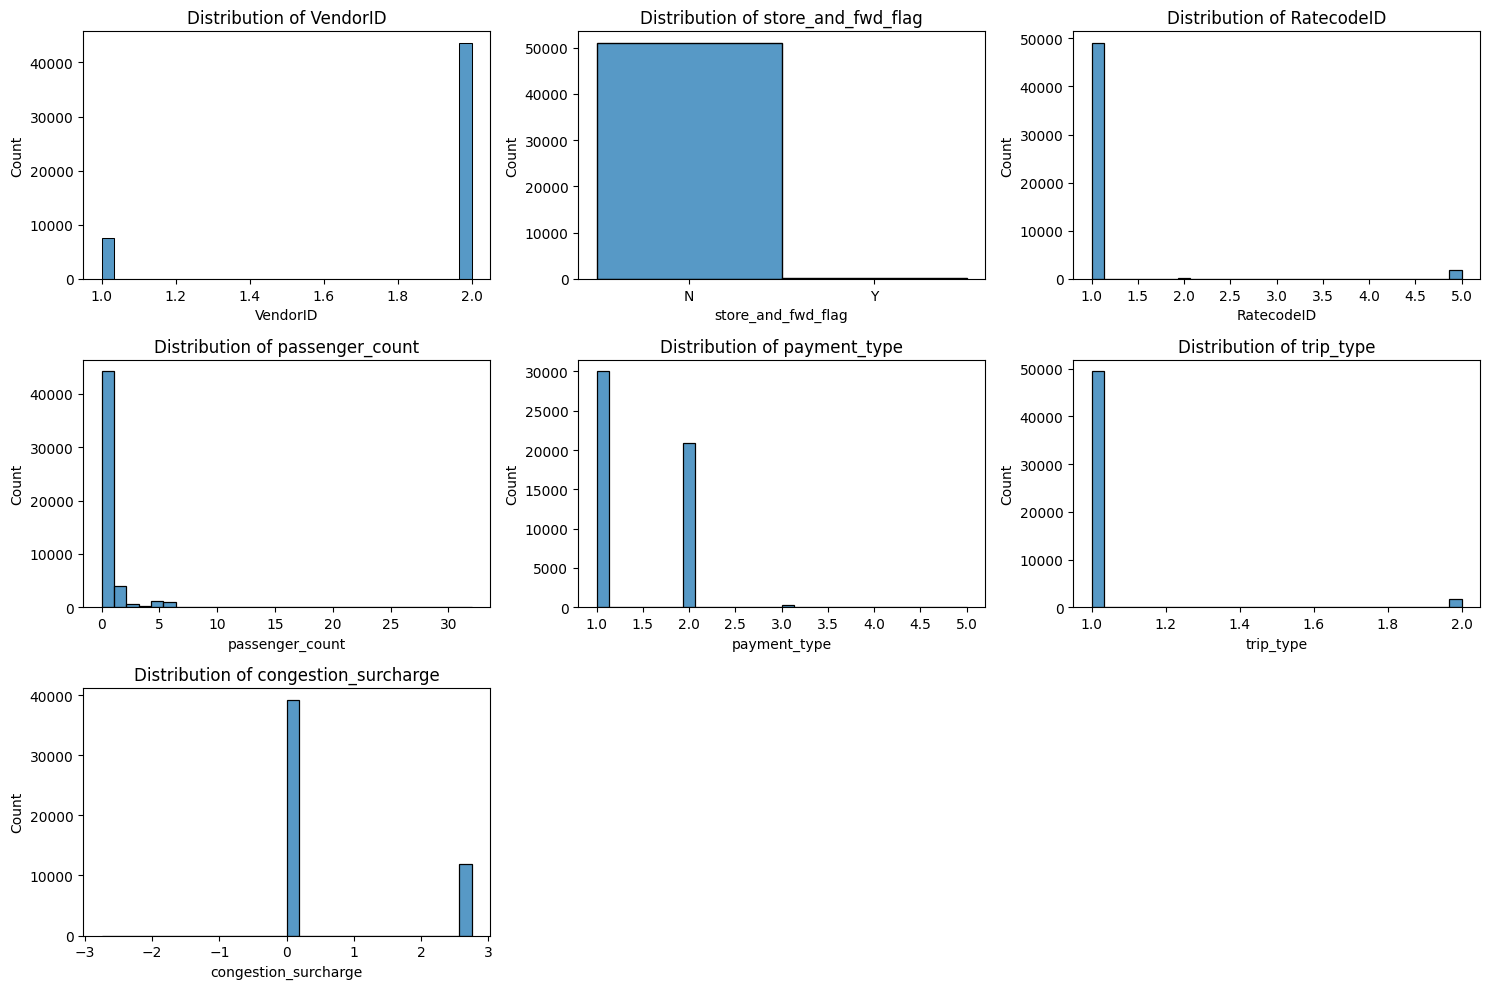

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop the 'ehail_fee' column
#data.drop('ehail_fee', axis=1, inplace=True)

# Columns with missing values (excluding 'ehail_fee')
columns_with_missing_values = ['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'passenger_count',
                               'payment_type', 'trip_type', 'congestion_surcharge']

data['store_and_fwd_flag'] = data['store_and_fwd_flag'].astype('category')

# Visualization
plt.figure(figsize=(15, 10))
for idx, col in enumerate(columns_with_missing_values, start=1):
    plt.subplot(3, 3, idx)
    if data[col].dtype == 'object':  # For categorical columns
        sns.countplot(data[col])
    else:  # For numerical columns
        sns.histplot(data[col], bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

## Imputation

In [22]:
# Impute missing values based on mode for the specified columns
for col in columns_with_missing_values:
    mode_value = data[col].mode()[0]
    data[col].fillna(mode_value, inplace=True)

# Verify if there are any remaining missing values
remaining_missing_values = data.isnull().sum()
remaining_missing_values[remaining_missing_values > 0]

Series([], dtype: int64)

## Handling Outliers

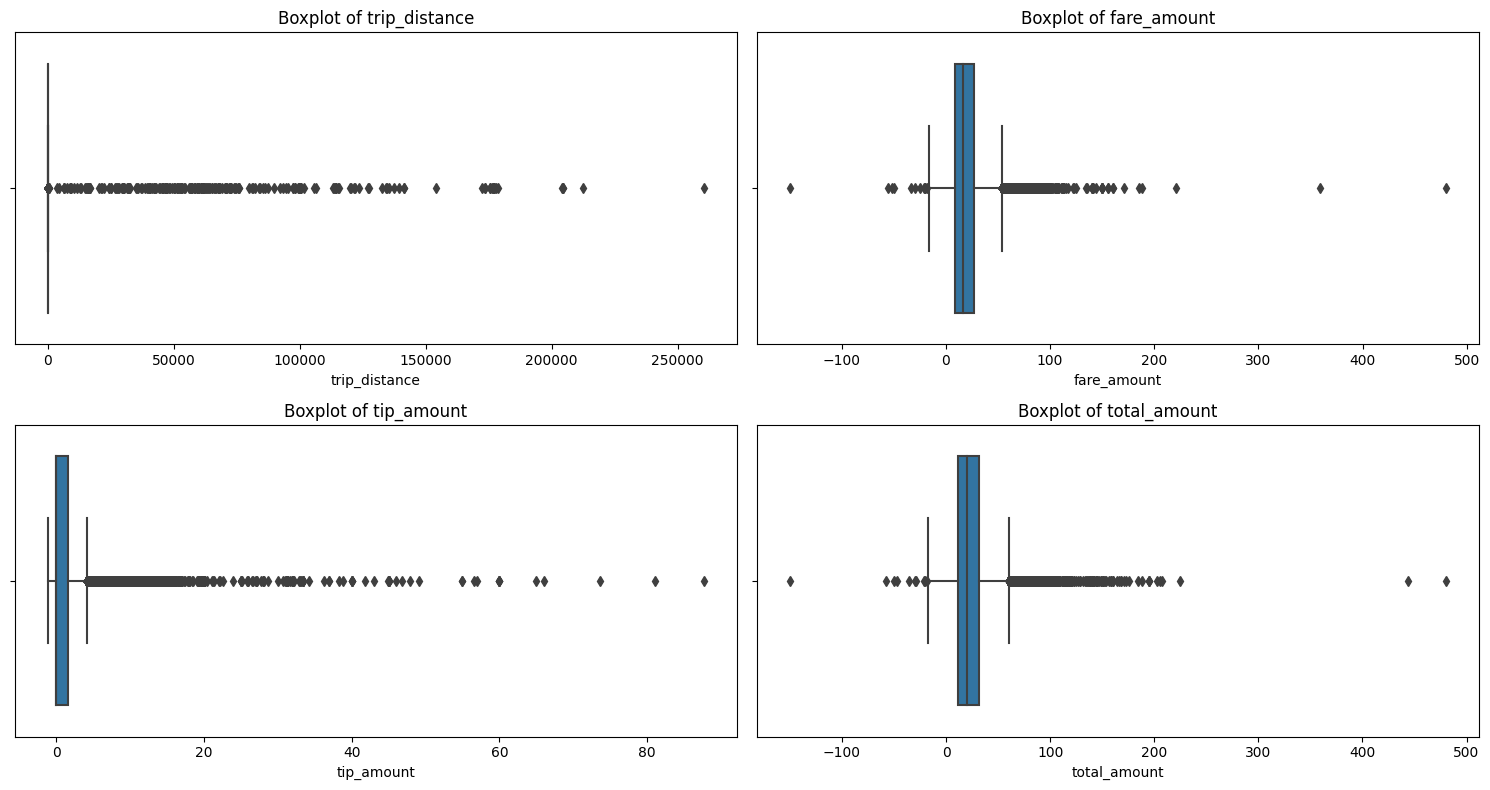

In [23]:
# Key numerical columns for boxplot visualization
key_numerical_columns = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount']

plt.figure(figsize=(15, 8))
for idx, col in enumerate(key_numerical_columns, start=1):
    plt.subplot(2, 2, idx)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.show()

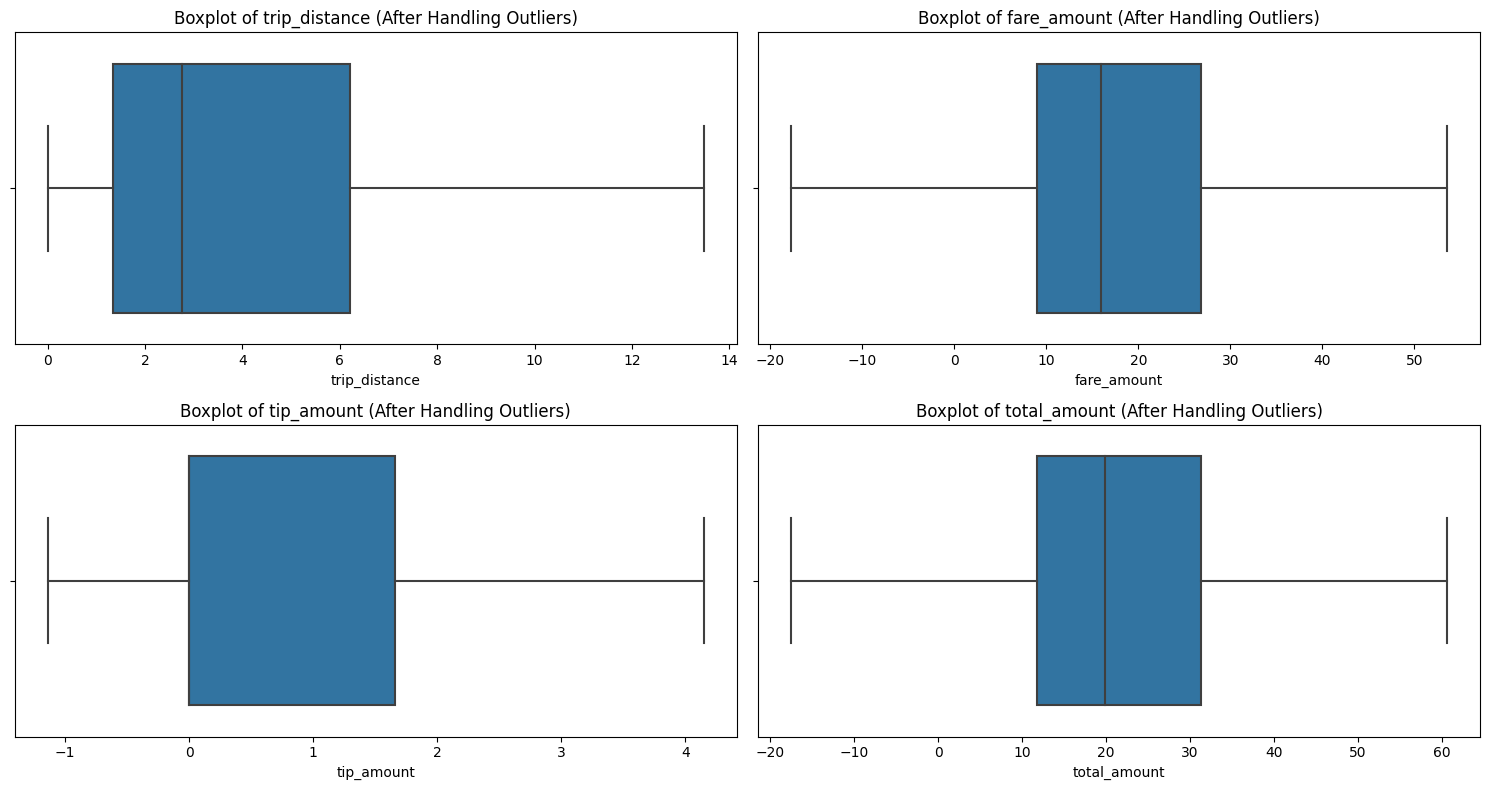

In [24]:
# Handling outliers using the IQR method
for col in key_numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR

    # Replace outliers with boundary values
    data[col] = data[col].apply(lambda x: lower_boundary if x < lower_boundary else (upper_boundary if x > upper_boundary else x))

# Visualize the boxplots again to verify the handling of outliers
plt.figure(figsize=(15, 8))
for idx, col in enumerate(key_numerical_columns, start=1):
    plt.subplot(2, 2, idx)
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col} (After Handling Outliers)')
    plt.tight_layout()

plt.show()

## Correlations

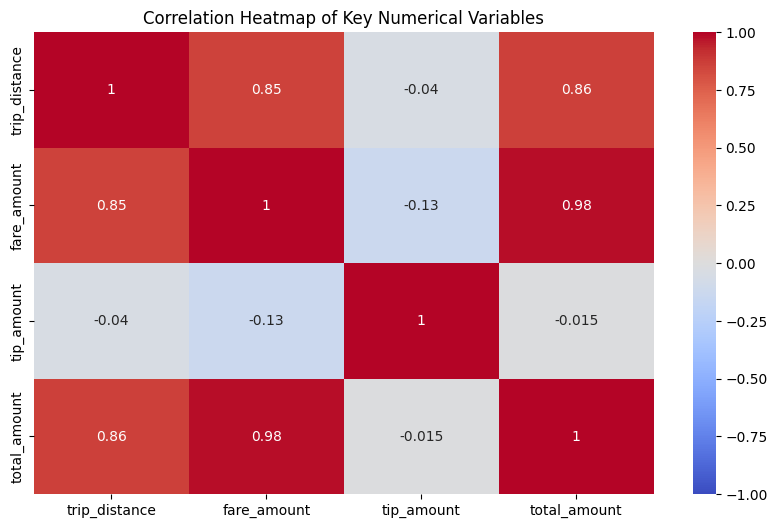

In [25]:
# Calculate correlations among the key numerical columns
correlations = data[key_numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Numerical Variables')
plt.show()

In [26]:
correlations

,trip_distance,fare_amount,tip_amount,total_amount
trip_distance,1.000000,0.852971,-0.039604,0.862759
fare_amount,0.852971,1.000000,-0.130962,0.983539
tip_amount,-0.039604,-0.130962,1.000000,-0.015093
total_amount,0.862759,0.983539,-0.015093,1.000000


## Handling Anomalies

In [27]:
# Examine the unique values and their counts for categorical variables
categorical_columns = ['store_and_fwd_flag', 'VendorID', 'RatecodeID', 'payment_type', 'trip_type']

categorical_values = {}
for col in categorical_columns:
    categorical_values[col] = data[col].value_counts()

categorical_values

{'store_and_fwd_flag': N    83495
 Y      196
 Name: store_and_fwd_flag, dtype: int64,
 'VendorID': 2.0    76072
 1.0     7619
 Name: VendorID, dtype: int64,
 'RatecodeID': 1.0    81512
 5.0     1954
 2.0      158
 4.0       41
 3.0       26
 Name: RatecodeID, dtype: int64,
 'payment_type': 1.0    62508
 2.0    20831
 3.0      307
 4.0       44
 5.0        1
 Name: payment_type, dtype: int64,
 'trip_type': 1.0    81931
 2.0     1760
 Name: trip_type, dtype: int64}

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


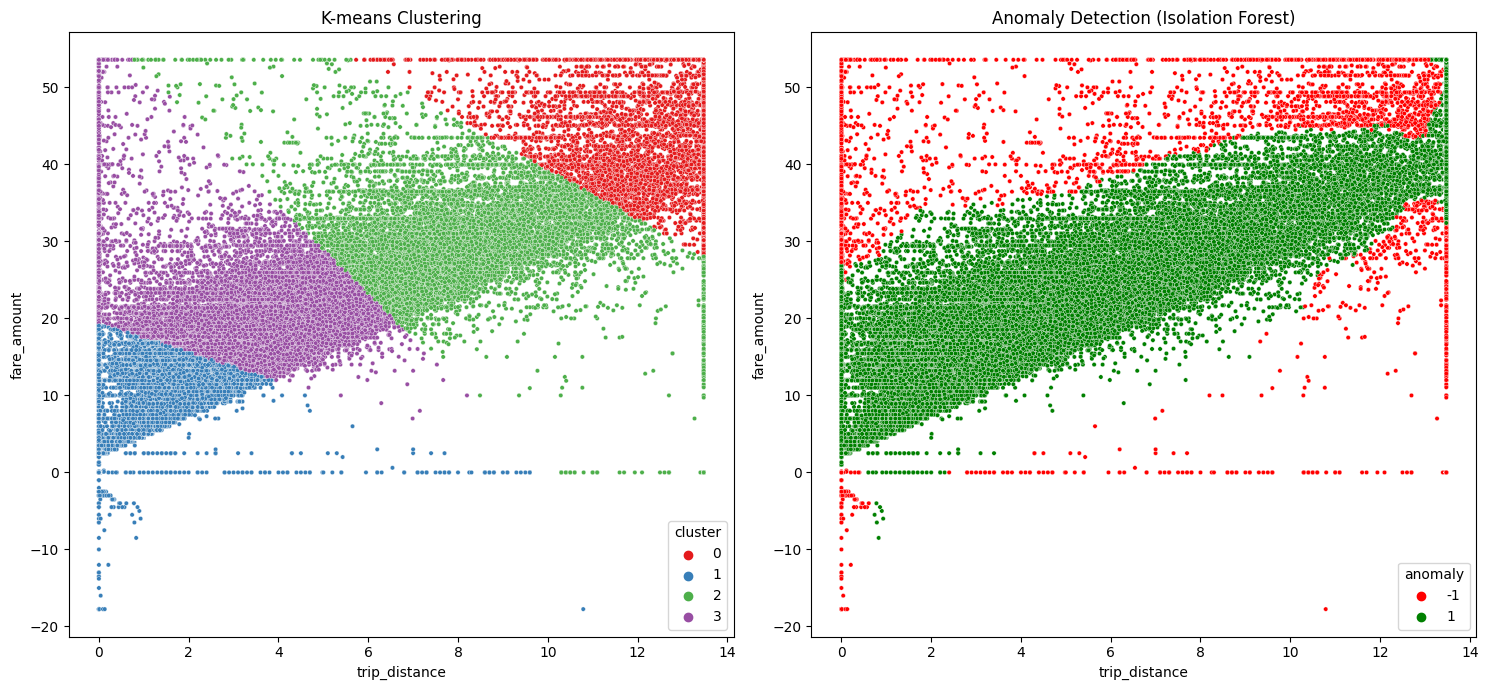

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

# Features for clustering and anomaly detection
features = ['trip_distance', 'fare_amount']

# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

# Clustering using k-means
kmeans = KMeans(n_clusters=4, random_state=42)
data['cluster'] = kmeans.fit_predict(scaled_data)

# Anomaly detection using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
data['anomaly'] = iso_forest.fit_predict(scaled_data)

# Visualize the clustering and anomalies
plt.figure(figsize=(15, 7))

# Clustering visualization
plt.subplot(1, 2, 1)
sns.scatterplot(x=data['trip_distance'], y=data['fare_amount'], hue=data['cluster'], palette='Set1', s=10)
plt.title('K-means Clustering')

# Anomaly visualization
plt.subplot(1, 2, 2)
sns.scatterplot(x=data['trip_distance'], y=data['fare_amount'], hue=data['anomaly'], palette=['red', 'green'], s=10)
plt.title('Anomaly Detection (Isolation Forest)')

plt.tight_layout()
plt.show()

In [29]:
# Cluster counts
cluster_counts = data['cluster'].value_counts()

# Anomaly counts (Note: -1 indicates an anomaly in Isolation Forest's output)
anomaly_counts = data['anomaly'].value_counts()

cluster_counts, anomaly_counts

(1    38073
 3    22892
 2    12466
 0    10260
 Name: cluster, dtype: int64,
  1    79506
 -1     4185
 Name: anomaly, dtype: int64)

## Feature Selection

In [30]:
# Convert datetime columns to datetime datatype
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])
data['lpep_dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'])

# Extract time features
data['pickup_hour'] = data['lpep_pickup_datetime'].dt.hour
data['pickup_day'] = data['lpep_pickup_datetime'].dt.day
data['pickup_dayofweek'] = data['lpep_pickup_datetime'].dt.dayofweek
data['dropoff_hour'] = data['lpep_dropoff_datetime'].dt.hour
data['dropoff_day'] = data['lpep_dropoff_datetime'].dt.day
data['dropoff_dayofweek'] = data['lpep_dropoff_datetime'].dt.dayofweek

# Calculate trip duration in minutes
data['trip_duration'] = (data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']).dt.total_seconds() / 60

# Calculate average speed in miles per hour
data['avg_speed'] = data['trip_distance'] / (data['trip_duration'] / 60)

# Display the first few rows to verify the new features
data[['lpep_pickup_datetime', 'pickup_hour', 'pickup_day', 'pickup_dayofweek', 'trip_duration', 'avg_speed']].head()

,lpep_pickup_datetime,pickup_hour,pickup_day,pickup_dayofweek,trip_duration,avg_speed
0,2021-07-01 00:30:52,0,1,3,4.733333,15.211268
1,2021-07-01 00:25:36,0,1,3,35.916667,22.510441
2,2021-07-01 00:05:58,0,1,3,6.033333,9.447514
3,2021-07-01 00:41:40,0,1,3,5.716667,13.014577
4,2021-07-01 00:51:32,0,1,3,7.233333,9.124424


In [37]:
import numpy as np

# Check for infinite values in the data
infinite_values = (data[features] == float('inf')).sum()

# Replace infinite values with NaN for further handling
data.replace([float('inf'), float('-inf')], np.nan, inplace=True)

# For simplicity, we can replace NaN values with the median of the respective columns
for col in features:
    median_value = data[col].median()
    data[col].fillna(median_value, inplace=True)

infinite_values

VendorID                 0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
pickup_hour              0
pickup_day               0
pickup_dayofweek         0
dropoff_hour             0
dropoff_day              0
dropoff_dayofweek        0
trip_duration            0
avg_speed                9
dtype: int64

In [39]:
# Replace infinite values with NaN
data.replace([float('inf'), float('-inf')], np.nan, inplace=True)

# For simplicity, replace NaN values with the median of the respective columns
for col in features:
    median_value = data[col].median()
    data[col].fillna(median_value, inplace=True)

In [40]:
from sklearn.ensemble import RandomForestRegressor

# Features and target variable
features = ['VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID', 'passenger_count', 'trip_distance',
            'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
            'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge', 'pickup_hour', 'pickup_day',
            'pickup_dayofweek', 'dropoff_hour', 'dropoff_day', 'dropoff_dayofweek', 'trip_duration', 'avg_speed']
target = 'total_amount'

data = data.dropna()

# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf.fit(data[features], data[target])

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
feature_importances

total_amount             9.998644e-01
fare_amount              1.320634e-04
improvement_surcharge    1.962532e-06
mta_tax                  9.010582e-07
trip_duration            2.433513e-07
PULocationID             6.849800e-08
dropoff_hour             6.249650e-08
DOLocationID             5.970697e-08
dropoff_dayofweek        4.121031e-08
pickup_dayofweek         3.740164e-08
tip_amount               3.397349e-08
trip_distance            3.102808e-08
dropoff_day              2.372865e-08
pickup_hour              2.014934e-08
pickup_day               1.277225e-08
avg_speed                1.275812e-08
extra                    9.028983e-09
congestion_surcharge     3.462469e-09
tolls_amount             3.236394e-09
trip_type                2.130029e-09
payment_type             1.914699e-09
RatecodeID               1.712040e-09
VendorID                 9.037029e-10
passenger_count          1.628628e-10
dtype: float64

## Linear Regression

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Instantiate and fit the linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the test set
lr_predictions = lr.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the linear regression model
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mse

9.681627735355031e-27

## Random Forest Regressor

In [42]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate and fit the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_regressor.predict(X_test)

# Calculate the Mean Squared Error (MSE) for the random forest regressor
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mse

5.764234393685394e-05

## Ensemple

In [43]:
# Ensemble predictions: Averaging predictions from linear regression and random forest regressor
ensemble_predictions = (lr_predictions + rf_predictions) / 2

# Calculate the Mean Squared Error (MSE) for the ensemble model
ensemble_mse = mean_squared_error(y_test, ensemble_predictions)
ensemble_mse

1.441058598422009e-05